<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/scratchpad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Dataset homepage: http://ai.stanford.edu/~acoates/stl10/
- The Python script comes from: https://github.com/mttk/STL10/

In [0]:
!wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py

In [0]:
!python stl10_input.py

In [0]:
!sudo apt-get install tree

In [0]:
!mkdir stl10
!cp -r train stl10/
!cp -r test stl10/
!cp -r unlabeled stl10/

In [36]:
!tree --dirsfirst --filelimit 10 stl10

stl10
├── test
│   ├── 1 [800 entries exceeds filelimit, not opening dir]
│   ├── 10 [800 entries exceeds filelimit, not opening dir]
│   ├── 2 [800 entries exceeds filelimit, not opening dir]
│   ├── 3 [800 entries exceeds filelimit, not opening dir]
│   ├── 4 [800 entries exceeds filelimit, not opening dir]
│   ├── 5 [800 entries exceeds filelimit, not opening dir]
│   ├── 6 [800 entries exceeds filelimit, not opening dir]
│   ├── 7 [800 entries exceeds filelimit, not opening dir]
│   ├── 8 [800 entries exceeds filelimit, not opening dir]
│   └── 9 [800 entries exceeds filelimit, not opening dir]
├── train
│   ├── 1 [500 entries exceeds filelimit, not opening dir]
│   ├── 10 [500 entries exceeds filelimit, not opening dir]
│   ├── 2 [500 entries exceeds filelimit, not opening dir]
│   ├── 3 [500 entries exceeds filelimit, not opening dir]
│   ├── 4 [500 entries exceeds filelimit, not opening dir]
│   ├── 5 [500 entries exceeds filelimit, not opening dir]
│   ├── 6 [500 entries exceed

In [0]:
# Set up GCP
PROJECT_ID = "fast-ai-exploration"
!gcloud config set project $PROJECT_ID
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [0]:
# Create a GCS bucket and copy the images
!gsutil mb gs://stl10
!gsutil -m cp -r train gs://stl10
!gsutil -m cp -r test gs://stl10
!gsutil -m cp -r unlabeled gs://stl10

In [0]:
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt

In [0]:
train_images = list(paths.list_images("train"))

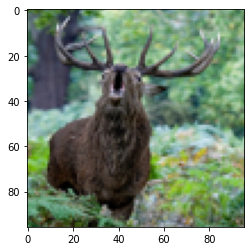

In [103]:
idx = np.random.choice(len(train_images), 1)
sample_training_image = train_images[int(idx)]
image = plt.imread(sample_training_image)
plt.imshow(image)
plt.show()

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import numpy as np

np.random.seed(0)

In [0]:
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size=int(0.1 * 96), min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = sample.numpy()
        sample = sample.squeeze(0)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return tf.convert_to_tensor(np.expand_dims(sample, 0))

In [0]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomContrast(factor=0.7),
    layers.experimental.preprocessing.RandomCrop(height=45, width=45),
    layers.Lambda(GaussianBlur())
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


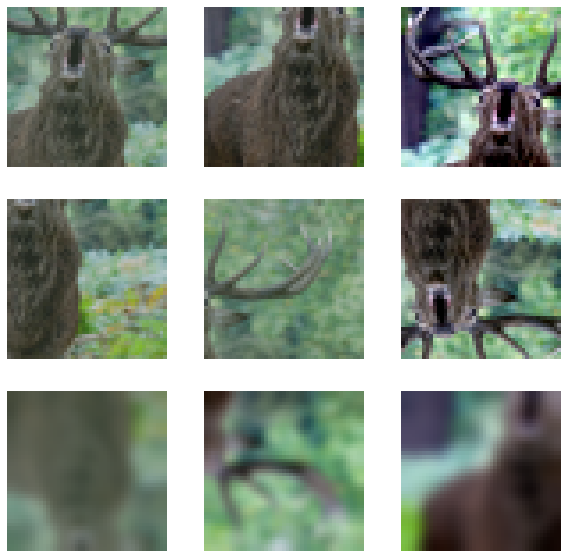

In [118]:
image = plt.imread(sample_training_image)
image = tf.convert_to_tensor(image)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0), training=True)
    plt.imshow(augmented_image[0].numpy())
    plt.axis('off')